In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import torch

In [45]:
def data_loader(folder_name, row=10, col=10, pixelnum = 950):
  '''
  Loads the multiple sets of diffraction into a numpy array

  Inputs:
  - folder_name: folder directory that contains all diffraction dataset
  - row: Number of diffraction patterns per row
  - col:  Number of diffraction patterns per column
  - pixelnum: Pixel size of each diffraction pattern (pixelnum x pixelnum)

  Returns:
  - data: Array of diffraction patterns (Num of Set, row * col, pixelnum, pixelnum)
  - label: Array of reconstructed image (Num of Set, 2, 1, 650, 650)
  '''
  num_data = len(next(os.walk(folder_name))[1])
  data = np.empty([num_data, row * col, pixelnum, pixelnum])
  label = np.empty([num_data, 2, 1, 650, 650])
  for i, folder in enumerate(list(os.walk(folder_name))[1:]):
    # label[i, 0] = np.pi*(2*(np.array(Image.open(folder[0] + "/phase_result.png").convert('L'))/255) - 1) # range: [-pi,pi]
    label[i, 0] = np.array(Image.open(folder[0] + "/phase_result.png").convert('L'))/255 #range [0,1]
    label[i, 1] = np.array(Image.open(folder[0] + "/amp_result.png").convert('L'))/255
    for x in range(row):
      for y in range(col):
        data[i,10*x + y] = np.array(Image.open(folder[0] + "/" + str(x+1) + "_" + str(y+1) + ".PNG"))[700:1650, 560:1510]/255
  return data, label

In [46]:
def single_data_loader(folder_name, row=10, col=10, pixelnum = 950):
  '''
  Loads a single set of diffraction patterns into a numpy array

  Inputs:
  - folder_name: folder directory that contains all diffraction dataset
  - row: Number of diffraction patterns per row
  - col:  Number of diffraction patterns per column
  - pixelnum: Pixel size of each diffraction pattern (pixelnum x pixelnum)

  Returns:
  - data: Array of diffraction patterns (1, row * col, pixelnum, pixelnum)
  - label: Array of reconstructed phase and amplitude images (1, 2, 1, 650, 650)
  '''
  data = np.empty([1, row * col, pixelnum, pixelnum])
  label = np.empty([1, 2, 1, 650, 650])
  label[0,0] = np.pi*(2*np.array(Image.open(folder_name + "/phase_result.png").convert('L'))/255 - 1)
  label[0,1] = np.array(Image.open(folder_name + "/amp_result.png").convert('L'))/255
  for x in range(row):
    for y in range(col):
      data[0,10*x + y] = np.array(Image.open(folder_name + "/" + str(x+1) + "_" + str(y+1) + ".PNG"))[700:1650, 560:1510]/255
  return data, label

In [47]:
def center_crop(imgs, pix_offset, x_start, y_start):
  '''
  Crops the images of each diffraction pattern and creates a grid image of 
  all diffraction patterns per set

  Inputs:
  - imgs: Array of diffraction patterns (Num of Sets, row * col, pixelnum, pixelnum)
  - pix_offset: size of desired cropped diffraction pattern (pix_offset x pix_offset)
  - x_start: starting index for cropping in x axis
  - y_start: starting index for cropping in y axis

  Returns:
  - grid_img: array of images of grid of diffraction patterns (Num of Set, 1, row * pix_offset, col * pix_offset)
  '''
  num_imgs = imgs.shape[1]
  grid_dim = int(np.sqrt(num_imgs))
  if(grid_dim**2 != num_imgs):
    print("Can not produce a grid with",num_imgs,"images")
    return

  num_set = imgs.shape[0]
  x_end = x_start + pix_offset
  y_end = y_start + pix_offset
  grid_img = np.zeros((num_set, grid_dim * grid_dim, pix_offset, pix_offset))
  for i in range(num_set):
    for j, img in enumerate(imgs[i]):
      grid_img[i, j] = img[x_start:x_end ,y_start:y_end]
  grid_img = np.flip(grid_img.reshape(num_set, grid_dim, grid_dim, pix_offset, pix_offset), axis=2)
  return np.einsum('...ikjl', grid_img).reshape(num_set, 1, grid_dim * pix_offset, grid_dim * pix_offset)

In [53]:
def grid_generator(imgs, pix_offset, x_start, y_start):
  '''
  Crops the images of each diffraction pattern and creates a grid image of 
  all diffraction patterns per set

  Inputs:
  - imgs: Array of diffraction patterns (Num of Sets, row * col, pixelnum, pixelnum)
  - pix_offset: size of desired cropped diffraction pattern (pix_offset x pix_offset)
  - x_start: starting index for cropping in x axis
  - y_start: starting index for cropping in y axis

  Returns:
  - grid_img: array of images of grid of diffraction patterns (Num of Set, 1, row * pix_offset, col * pix_offset)
  '''
  num_imgs = imgs.shape[1]
  grid_dim = int(np.sqrt(num_imgs))
  if(grid_dim**2 != num_imgs):
    print("Can not produce a grid with",num_imgs,"images")
    return

  num_set = imgs.shape[0]
  x_end = x_start + pix_offset
  y_end = y_start + pix_offset
  grid_img = np.zeros((num_set, grid_dim * grid_dim, pix_offset, pix_offset))
  for i in range(num_set):
    for j, img in enumerate(imgs[i]):
      grid_img[i, j] = img[x_start:x_end ,y_start:y_end]
  grid_img = np.flip(grid_img.reshape(num_set, grid_dim, grid_dim, pix_offset, pix_offset), axis=2)
  return np.einsum('...ikjl', grid_img).reshape(num_set, 1, grid_dim * pix_offset, grid_dim * pix_offset)

In [49]:
def compressed_grid_generator(imgs, pix_offset, x_start, y_start, factor=4):
  '''
  Crops the images of each diffraction pattern and creates a compressed image of grid of 
  all diffraction patterns per set

  Inputs:
  - imgs: Array of diffraction patterns (Num of Sets, row * col, pixelnum, pixelnum)
  - pix_offset: size of desired cropped diffraction pattern (pix_offset x pix_offset)
  - x_start: starting index for cropping in x axis
  - y_start: starting index for cropping in y axis

  Returns:
  - grid_img: array of images of grid of diffraction patterns (Num of Set, 1, row * pix_offset, col * pix_offset)
  '''
  num_imgs = imgs.shape[1]
  grid_dim = int(np.sqrt(num_imgs))
  if(grid_dim**2 != num_imgs):
    print("Can not produce a grid with",num_imgs,"images")
    return

  num_set = imgs.shape[0]
  x_end = x_start + pix_offset
  y_end = y_start + pix_offset
  grid_img = np.zeros((num_set, grid_dim * grid_dim, pix_offset, pix_offset))
  for i in range(num_set):
    for j, img in enumerate(imgs[i]):
      grid_img[i, j] = img[x_start:x_end ,y_start:y_end]
  grid_img = np.flip(grid_img.reshape(num_set, grid_dim, grid_dim, pix_offset, pix_offset), axis=2)
  grid_img = np.einsum('...ikjl', grid_img).reshape(num_set, 1, grid_dim * pix_offset, grid_dim * pix_offset)
  
  compressed_img = nn.functional.max_pool2d(torch.tensor(grid_img), 3, stride=factor).numpy()

  return compressed_img

In [50]:
# all diffraction images from google drive are stored in a "diffractions" folder 
# (lmk if youre trying to mimic the set up for the code to work)
diffraction_data, label = data_loader("/home/rnakaha2/documents/research/diffractions/")

Check Cropping Boundaries

<Figure size 432x288 with 0 Axes>

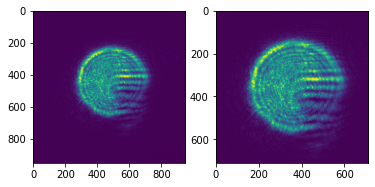

In [52]:
plt.figure()
f, ax = plt.subplots(1,2) 
ax[0].imshow(diffraction_data[0,6], cmap='viridis')
ax[1].imshow(diffraction_data[0,6, 90:800, 120:830])

Generate Compressed/Non-Compressed Diffraction Grids

In [54]:
diff_grid = grid_generator(diffraction_data, 710, 90, 120)
compressed_diff_grid = compressed_grid_generator(diffraction_data, 710, 90, 120)
print(diff_grid.shape)
print(compressed_diff_grid.shape)

(4, 1, 7100, 7100)
(4, 1, 1775, 1775)


Save Data as .npz

In [ ]:
np.savez_compressed('dataset/diffraction_data', diffraction_data)
np.savez_compressed('dataset/diffraction_label', label)
np.savez_compressed('dataset/diff_grid', diff_grid)
np.savez_compressed('dataset/compressed_diff_grid', compressed_diff_grid)

In [55]:
diffraction_data = np.load('dataset/diffraction_data.npz')['arr_0']
diff_grid = np.load('dataset/diff_grid.npz')['arr_0']
compressed_diff_grid = np.load('dataset/compressed_diff_grid.npz')['arr_0']
label = np.load('dataset/norm_diffraction_label.npz')['arr_0']
non_norm_label = np.load('dataset/diffraction_label.npz')['arr_0']

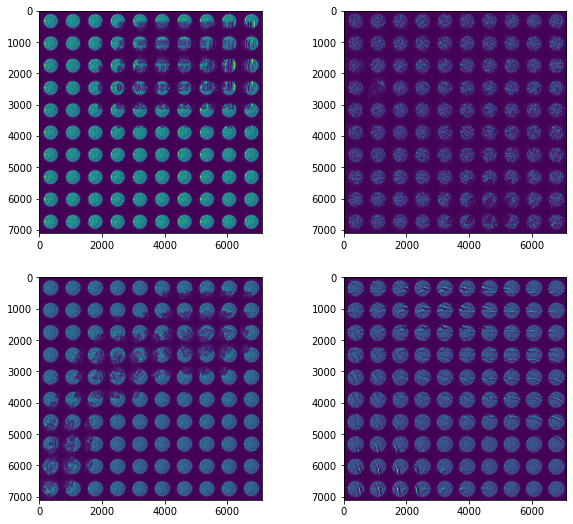

In [56]:
f, ax = plt.subplots(2,2, figsize=(10, 9))
im = ax[0,0].imshow(diff_grid[0,0])
ax[1,0].imshow(diff_grid[1,0])
ax[0,1].imshow(diff_grid[2,0])
ax[1,1].imshow(diff_grid[3,0])

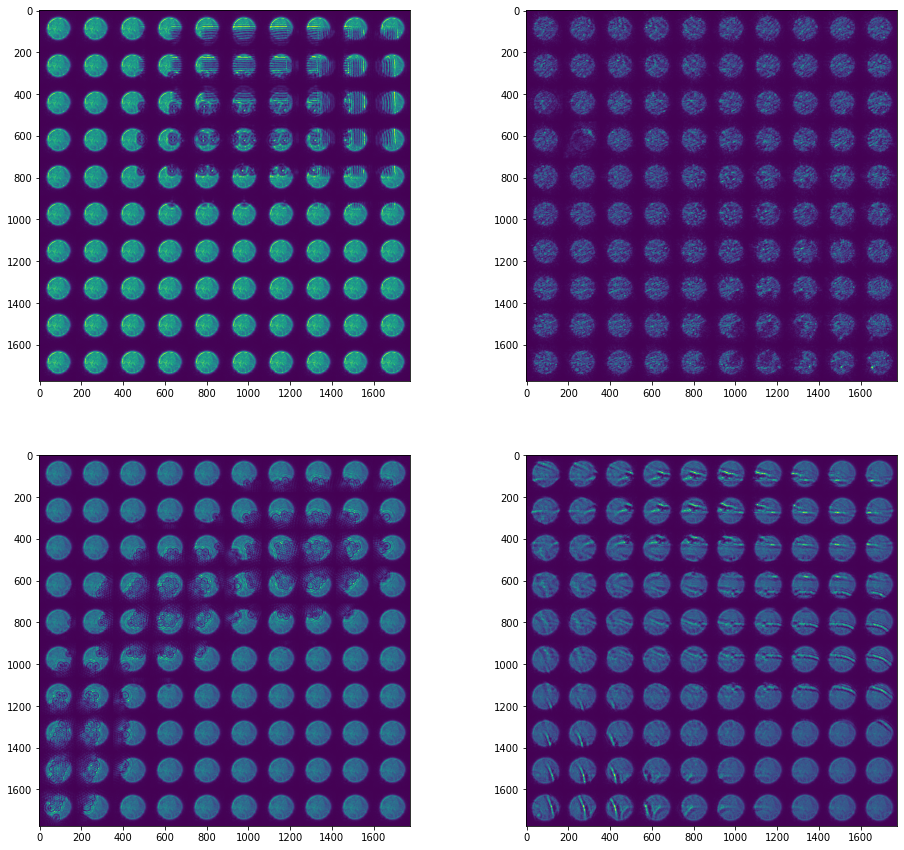

In [ ]:
f, ax = plt.subplots(2,2, figsize=(10, 9))
ax[0,0].imshow(compressed_diff_grid[0,0])
ax[1,0].imshow(compressed_diff_grid[1,0])
ax[0,1].imshow(compressed_diff_grid[2,0])
ax[1,1].imshow(compressed_diff_grid[3,0])

Visualize Ground Truth Data (Normalized `[0,1]` and Non-Normalized `[-pi,pi]`)

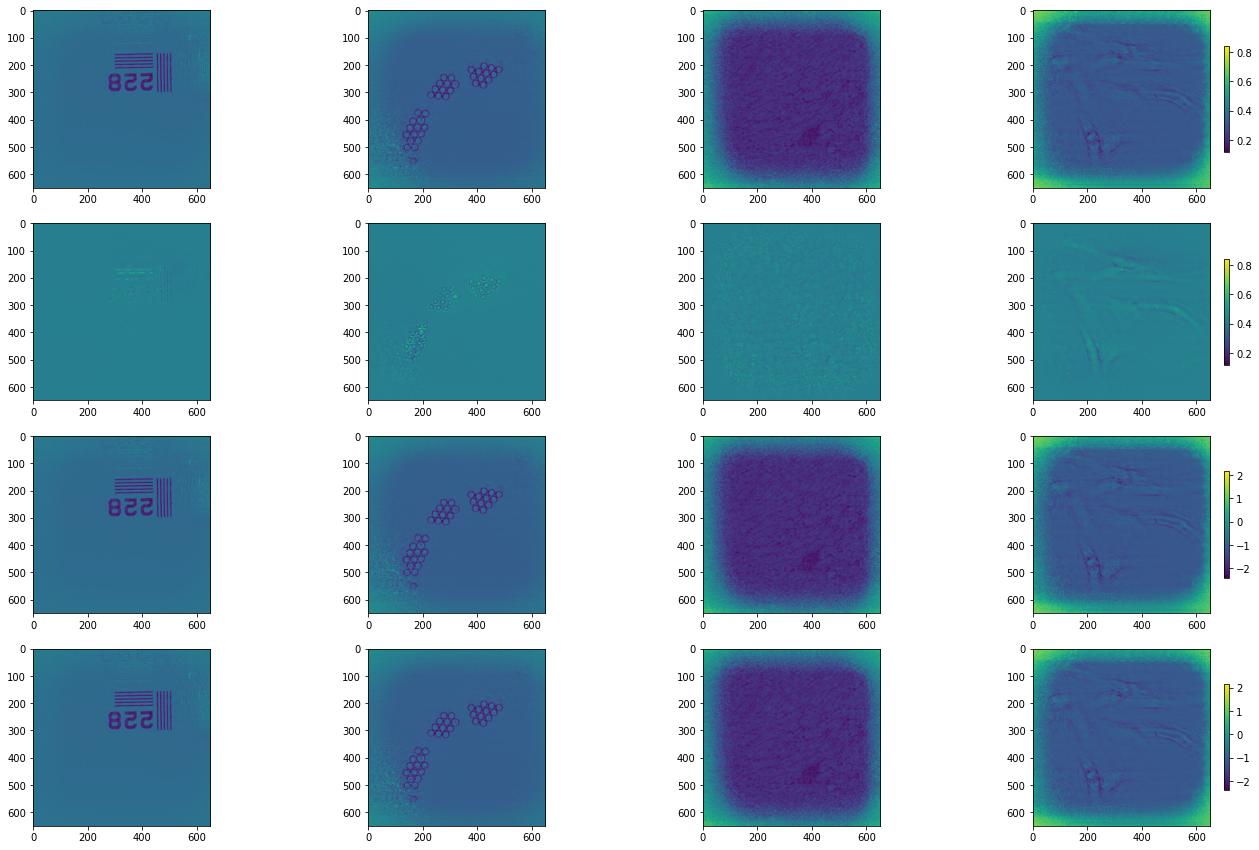

In [ ]:
f, ax = plt.subplots(4,4, figsize=(17, 15))
# Amplitude [0,1]
ax[0,0].imshow(label[0,0,0])
ax[0,1].imshow(label[1,0,0])
ax[0,2].imshow(label[2,0,0])
amp = ax[0,3].imshow(label[3,0,0])
f.colorbar(amp, ax=ax[0, 3], shrink=0.6)
# Phase [0,1]
ax[1,0].imshow(label[0,1,0])
ax[1,1].imshow(label[1,1,0])
ax[1,2].imshow(label[2,1,0])
ph = ax[1,3].imshow(label[3,1,0])
f.colorbar(ph, ax=ax[1, 3], shrink=0.6)
# Phase [-pi,pi] unnormalized
ax[2,0].imshow((2*label[0,0,0]-1)*np.pi)
ax[2,1].imshow((2*label[1,0,0]-1)*np.pi)
ax[2,2].imshow((2*label[2,0,0]-1)*np.pi)
img = ax[2,3].imshow((2*label[3,0,0]-1)*np.pi)
f.colorbar(img, ax=ax[2, 3], shrink=0.6)
# Phase [-pi,pi] Original
ax[3,0].imshow(non_norm_label[0,0,0])
ax[3,1].imshow(non_norm_label[1,0,0])
ax[3,2].imshow(non_norm_label[2,0,0])
img = ax[3,3].imshow(non_norm_label[3,0,0])
f.colorbar(img, ax=ax[3, 3], shrink=0.6)